1 -Get the data

In [1]:
! git clone https://github.com/amanchadha/coursera-ai-for-medicine-specialization.git

fatal: destination path 'coursera-ai-for-medicine-specialization' already exists and is not an empty directory.


2 - explore the data

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
data = pd.read_csv('/content/coursera-ai-for-medicine-specialization/AI for Medical Treatment/Week 2/stanford_report_test.csv' , )

In [4]:
data.shape

(1000, 18)

In [5]:
data = data.reset_index(drop=True)

In [6]:
data.head(5)

,SimpleTestReportID,Report Impression,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Report Impression Parsed,Report Impression DG Paths
0,1.0,"\n \n1.mild pulmonary edema, and cardiomegaly....",NaN,NaN,1.0,NaN,NaN,1.0,-1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,['(S1 (S (S (S (LST (LS 1.)) (NP (JJ mild) (JJ...,['/data3/CXR-CHEST/dgs/GL66832b_GL6dd686/0.pkl...
1,2.0,\n \n1.unremarkable cardiomediastinal silhouet...,NaN,0.0,NaN,NaN,1.0,NaN,0.0,-1.0,NaN,0.0,0.0,NaN,1.0,NaN,['(S1 (S (S (NP (LST (LS 1.)) (NN unremarkable...,['/data3/CXR-CHEST/dgs/GL6f51db_GL6f51dd/0.pkl...
2,3.0,\n1. lines and tubes are unchanged in position...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,['(S1 (S (S (LST (LS 1.)) (NP (NP (NNS lines))...,['/data3/CXR-CHEST/dgs/GL666dde_GL6b021a/0.pkl...
3,4.0,\n1. postoperative portable film with a right-...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,['(S1 (S (S (LST (LS 1.)) (NP (NP (JJ postoper...,['/data3/CXR-CHEST/dgs/GL6a8d08_GL6d5d21/0.pkl...
4,6.0,\n \n1.single frontal view of the chest demons...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,['(S1 (S (S (NP (NP (LST (LS 1.)) (JJ single) ...,['/data3/CXR-CHEST/dgs/GL675b56_GL6f4eb9/0.pkl...


 3 - data cleaning

In [7]:
# first we will retain useful features in the dataset
data = data[['Report Impression','Cardiomegaly' ,'Lung Lesion' , 'Airspace Opacity' , 
            'Edema' , 'Consolidation' , 'Pneumonia' , 'Atelectasis' ,'Pneumothorax',
             'Pleural Effusion' , 'Pleural Other' , 'Fracture' ]] 

In [8]:
data.shape

(1000, 12)

In [9]:
data.head(5)

,Report Impression,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
0,"\n \n1.mild pulmonary edema, and cardiomegaly....",1.0,NaN,NaN,1.0,-1.0,NaN,1.0,NaN,1.0,NaN,NaN
1,\n \n1.unremarkable cardiomediastinal silhouet...,NaN,NaN,1.0,NaN,0.0,-1.0,NaN,0.0,0.0,NaN,1.0
2,\n1. lines and tubes are unchanged in position...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN
3,\n1. postoperative portable film with a right-...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
4,\n \n1.single frontal view of the chest demons...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN


In [10]:
# we will replace -1 values  and nan values with 0
data.fillna(0.0 , inplace = True)
data.replace(-1.0 , 0.0 ,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [11]:
unique_dic = {}
for i in data.columns :
  if i != 'Report Impression' :
      unique_dic[i] = data[i].unique()

In [12]:
unique_dic

{'Cardiomegaly': array([1., 0.]),
 'Lung Lesion': array([0., 1.]),
 'Airspace Opacity': array([0., 1.]),
 'Edema': array([1., 0.]),
 'Consolidation': array([0., 1.]),
 'Pneumonia': array([0., 1.]),
 'Atelectasis': array([1., 0.]),
 'Pneumothorax': array([0., 1.]),
 'Pleural Effusion': array([1., 0.]),
 'Pleural Other': array([0., 1.]),
 'Fracture': array([0., 1.])}

In [13]:
categories = [i for i in data.columns if i != 'Report Impression']

In [14]:
categories

['Cardiomegaly',
 'Lung Lesion',
 'Airspace Opacity',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture']

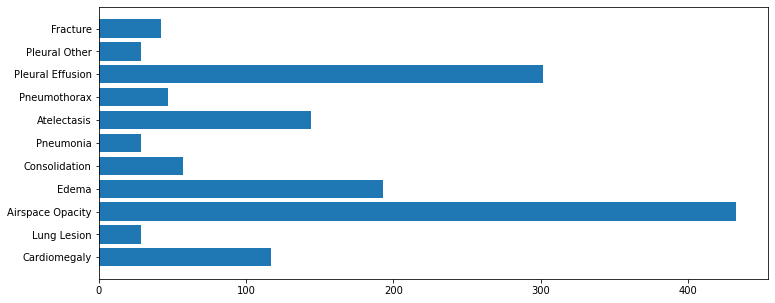

In [15]:
plt.figure(figsize=(12,5))
plt.barh(y=categories, width=[data[categories[i]].value_counts()[1] for i in range(len(categories)) ])
plt.show()

In [16]:
# You can see that pathologies like Airspace Opacity, Pleural Effusion, and Edema are present
# in many of the reports while Lung Lesion and Pneumonia are not as common in this dataset.

In [17]:
# we will see data distribution
data_distribution ={}
for i in range(len(categories)):
   count= data[categories[i]].value_counts()
   data_distribution[categories[i]] = count
data_distribution

{'Cardiomegaly': 0.0    883
 1.0    117
 Name: Cardiomegaly, dtype: int64, 'Lung Lesion': 0.0    971
 1.0     29
 Name: Lung Lesion, dtype: int64, 'Airspace Opacity': 0.0    567
 1.0    433
 Name: Airspace Opacity, dtype: int64, 'Edema': 0.0    807
 1.0    193
 Name: Edema, dtype: int64, 'Consolidation': 0.0    943
 1.0     57
 Name: Consolidation, dtype: int64, 'Pneumonia': 0.0    971
 1.0     29
 Name: Pneumonia, dtype: int64, 'Atelectasis': 0.0    856
 1.0    144
 Name: Atelectasis, dtype: int64, 'Pneumothorax': 0.0    953
 1.0     47
 Name: Pneumothorax, dtype: int64, 'Pleural Effusion': 0.0    698
 1.0    302
 Name: Pleural Effusion, dtype: int64, 'Pleural Other': 0.0    971
 1.0     29
 Name: Pleural Other, dtype: int64, 'Fracture': 0.0    958
 1.0     42
 Name: Fracture, dtype: int64}

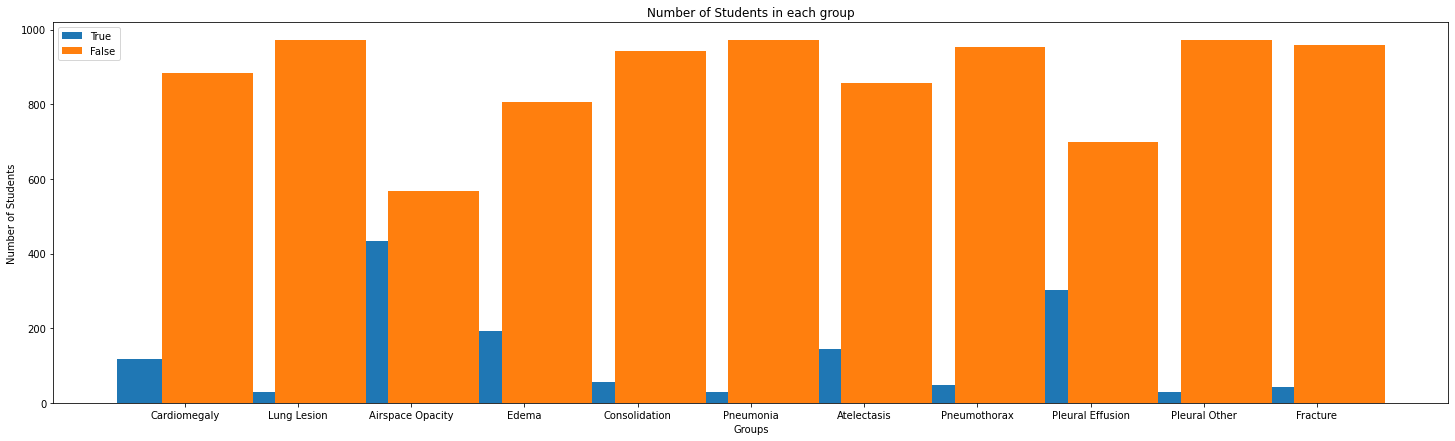

In [18]:
plt.figure(figsize=(25,7))
X_axis = np.arange(len(categories))
plt.bar(X_axis-0.2 , height=[data[categories[i]].value_counts()[1] for i in range(len(categories)) ]
         ,label='True')
plt.bar(X_axis+0.2, height=[data[categories[i]].value_counts()[0] for i in range(len(categories)) ]
          ,label='False')
plt.xticks(X_axis, categories)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

In [19]:
# we will handle imbalanced data
# so first we will split the data for each class
data_ = {}
for j in range(len(categories)):
  data_frame = data.drop([categories[i] for i in range(len(categories)) if categories[i] != categories[j]] , axis =1) # pd.concat([data['Report Impression'] , data[categories[i]]] ,axis =1)
  data_[categories[j]] = data_frame

In [20]:
def handle_imbalanced_values():
   for i in range(len(data_)):
     data_class_ = data_[categories[i]]
     data_class_1 = data_class_[data_class_[categories[i]] ==1]
     data_class_0 = data_class_[data_class_[categories[i]] ==0]
     data_class_1 = data_class_1.sample(data_class_0[categories[i]].value_counts()[0] , replace = True)
     new_data_class_ = pd.concat([data_class_1 ,data_class_0 ] , axis =0).reset_index(drop =True)
     data_[categories[i]] = new_data_class_

In [21]:
handle_imbalanced_values()

In [23]:
# we will see data_distribution now 
data_distribution ={}
for i in range(len(categories)):
   count= data_[categories[i]][categories[i]].value_counts()
   data_distribution[categories[i]] = count
data_distribution

{'Cardiomegaly': 1.0    883
 0.0    883
 Name: Cardiomegaly, dtype: int64, 'Lung Lesion': 1.0    971
 0.0    971
 Name: Lung Lesion, dtype: int64, 'Airspace Opacity': 1.0    567
 0.0    567
 Name: Airspace Opacity, dtype: int64, 'Edema': 1.0    807
 0.0    807
 Name: Edema, dtype: int64, 'Consolidation': 1.0    943
 0.0    943
 Name: Consolidation, dtype: int64, 'Pneumonia': 1.0    971
 0.0    971
 Name: Pneumonia, dtype: int64, 'Atelectasis': 1.0    856
 0.0    856
 Name: Atelectasis, dtype: int64, 'Pneumothorax': 1.0    953
 0.0    953
 Name: Pneumothorax, dtype: int64, 'Pleural Effusion': 1.0    698
 0.0    698
 Name: Pleural Effusion, dtype: int64, 'Pleural Other': 1.0    971
 0.0    971
 Name: Pleural Other, dtype: int64, 'Fracture': 1.0    958
 0.0    958
 Name: Fracture, dtype: int64}

In [163]:
# so the data now is balanced

In [24]:
for i in range(len(data_)):
   x_ = data_[categories[i]]['Report Impression']
   y_ = data_[categories[i]][categories[i]]
   data_[categories[i]] = (x_ , y_)

In [25]:
print(data_['Edema'][0].shape)
print(data_['Edema'][1].shape)

(1614,)
(1614,)


In [94]:
# we will do some data preprocessing 

In [26]:
print(data_['Edema'][0][0])


 
1.  single frontal view of the chest demonstrates a right ij central 
venous catheter in place with tip in upper right atrium.
 
2.  there is moderate cardiomegaly.
 
3.  lung volumes are low with a diffuse reticular pattern throughout 
the bilateral lung zones with more confluent left greater than right 
bibasilar air space opacities and small left greater than right 
bilateral pleural effusions. findings are suggestive of mild 
pulmonary edema with bibasilar atelectasis.
 



In [30]:
def data_preprocessing(data_):
  data_pre = {}
  ps = PorterStemmer()
  for j in range(len(data_)):
     data = data_[categories[j]][0]
     courps =[]
     for i in range(len(data)) :
       report = re.sub('[^a-zA-Z]', ' ', data[i])
       report = report.lower()
       report = report.split()
       report = [ps.stem(i) for i in report]
       report = ' '.join(report)
       courps.append(report)
     courps = np.array(courps)
     data_pre[categories[j]] = courps
  return data_pre

In [31]:
data_pre = data_preprocessing(data_)

In [32]:
data_pre['Edema'][1]

'cardiomegali with small effus and worsen edema'

In [34]:
voc_size = 1500

In [36]:
onehot_dic ={}
for i in range(len(data_pre)):
  list__= data_pre[categories[i]]
  onehot = [one_hot(word , voc_size) for word in list__ ]
  onehot_dic[categories[i]] = onehot

In [37]:
print(len(onehot[0]))
print(onehot[0])

50
[547, 1154, 247, 691, 1171, 1116, 154, 1134, 847, 380, 258, 353, 1272, 676, 1033, 562, 1290, 84, 932, 1141, 722, 1058, 591, 380, 611, 367, 73, 811, 1342, 1141, 1456, 867, 1456, 380, 72, 835, 1330, 681, 1141, 388, 1171, 1116, 154, 1208, 722, 813, 383, 763, 1247, 522]


In [38]:
max_lenght =181
embedded_docs_dic ={}
for i in range(len(categories)):
  embedded_docs=pad_sequences(onehot_dic[categories[i]],padding='post',maxlen=max_lenght)
  embedded_docs_dic[categories[i]] = embedded_docs

In [40]:
from sklearn.model_selection import train_test_split
x_y_dic = {}
for i in range(len(categories)):
  X_final=np.asarray(embedded_docs_dic[categories[i]]).astype(np.float32)
  y_final=np.asarray(data_[categories[i]][1])
  X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
  x_y_dic[categories[i]] = [X_train, X_test, y_train, y_test]

4 - train the model

In [41]:
def train_model(embedding_vector_features ,X_train,y_train,X_test,y_test ):
    model1=Sequential()
    model1.add(Embedding(voc_size,embedding_vector_features,input_length=max_lenght))
    model1.add(Bidirectional(LSTM(100)))
    model1.add(keras.layers.Dropout(0.3))
    model1.add(Dense(1,activation='sigmoid'))
    model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    history = model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)  
    return model1 , history

In [42]:
def train_each_model_alone():
  models = {}
  histories ={}
  for i in range(len(categories)):
    X_train = x_y_dic[categories[i]][0]
    y_train = x_y_dic[categories[i]][2]
    X_test = x_y_dic[categories[i]][1]
    y_test = x_y_dic[categories[i]][3]
    embedding_vector_features=40
    model1 , history = train_model(embedding_vector_features ,X_train,y_train,X_test,y_test )
    models[categories[i]] = model1
    histories[categories[i]] = history
  return models , histories

In [43]:
models , histories = train_each_model_alone()

Epoch 1/7
23/23 [==============================] - 14s 418ms/step - loss: 0.6860 - accuracy: 0.5800 - val_loss: 0.6583 - val_accuracy: 0.6328
Epoch 2/7
23/23 [==============================] - 8s 370ms/step - loss: 0.6100 - accuracy: 0.7195 - val_loss: 0.5623 - val_accuracy: 0.7232
Epoch 3/7
23/23 [==============================] - 8s 368ms/step - loss: 0.4973 - accuracy: 0.7996 - val_loss: 0.5157 - val_accuracy: 0.7514
Epoch 4/7
23/23 [==============================] - 8s 366ms/step - loss: 0.3749 - accuracy: 0.8562 - val_loss: 0.4753 - val_accuracy: 0.7825
Epoch 5/7
23/23 [==============================] - 8s 367ms/step - loss: 0.3246 - accuracy: 0.8789 - val_loss: 0.3931 - val_accuracy: 0.8644
Epoch 6/7
23/23 [==============================] - 8s 366ms/step - loss: 0.2408 - accuracy: 0.9235 - val_loss: 0.3749 - val_accuracy: 0.8616
Epoch 7/7
23/23 [==============================] - 8s 366ms/step - loss: 0.1776 - accuracy: 0.9483 - val_loss: 0.2863 - val_accuracy: 0.8785
Epoch 1/7
25

5 - we will compute score for each model

In [48]:
def score(models ):
  scores = []
  for i in range(len(categories)):
      X_test_ = x_y_dic[categories[i]][1]
      y_test_ = x_y_dic[categories[i]][3]
      score = models[categories[i]].evaluate(X_test_ , y_test_)[1]
      scores.append(score)
  return np.array(scores) 

In [49]:
scores = score(models)

12/12 [==============================] - 1s 61ms/step - loss: 0.1768 - accuracy: 0.9714


In [50]:
# we will compute mean score of all models
mean_score = scores.sum() / len(scores)
print(mean_score)

0.9616054621609774


6 - we will predict in all the models , confusion matrix and 
 classification report

In [52]:
def predict(models , data) :
  predictions_dic ={}
  for i in categories :
     model = models[i]
     prediction = model.predict(data[i][1])
     prediction =  np.where( prediction >0.5 , 1,0)
     predictions_dic[i] = prediction  
  return predictions_dic

In [53]:
predictions = predict(models , x_y_dic)

In [54]:
from sklearn.metrics import confusion_matrix
def compute_confusion_matrix(models ,data):
   matrixs = []
   for i in range(len(categories)):
      confusion_ = confusion_matrix(data[categories[i]][3] , predictions[categories[i]])
      matrixs.append(confusion_)
   return np.array(matrixs)   
    

In [57]:
matrixs = compute_confusion_matrix(models,x_y_dic )

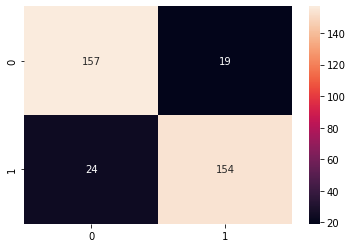

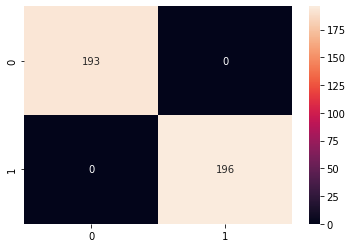

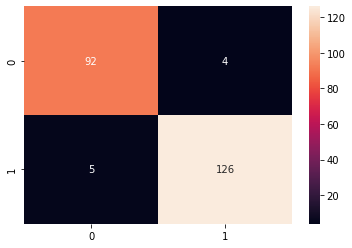

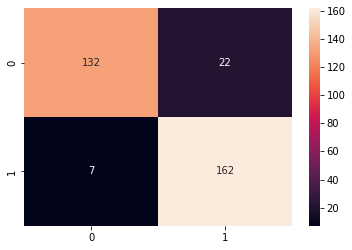

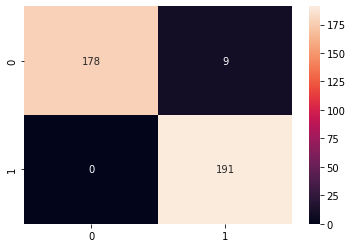

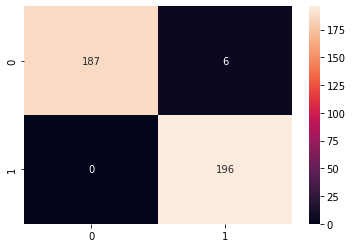

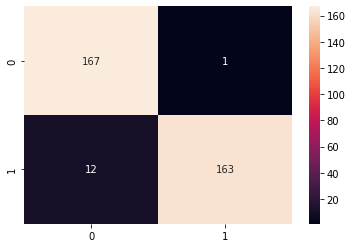

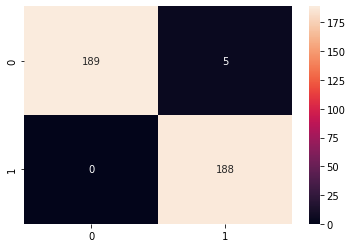

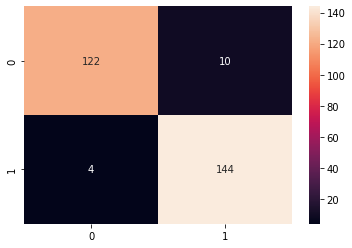

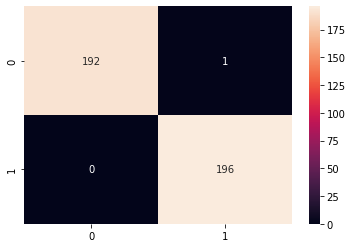

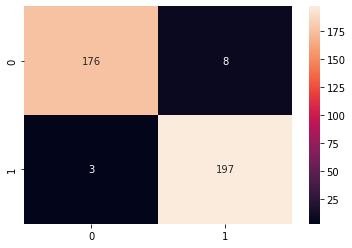

In [58]:
from matplotlib import pyplot as plt
import seaborn as sn
for i in range(len(matrixs)) :
   sn.heatmap(matrixs[i], annot=True, fmt='d')
   plt.show()

In [59]:
from sklearn.metrics import classification_report
def compute_classification_report(models,data):
   reports = []
   for i in range(len(categories)): 
      report_ = classification_report(data[categories[i]][3] , predictions[categories[i]])
      reports.append(report_)
   return np.array(reports) 

In [61]:
reports = compute_classification_report(models , x_y_dic)
for i in range(len(reports)) :
   print(categories[i])
   print(reports[i])

Cardiomegaly
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       176
         1.0       0.89      0.87      0.88       178

    accuracy                           0.88       354
   macro avg       0.88      0.88      0.88       354
weighted avg       0.88      0.88      0.88       354

Lung Lesion
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       193
         1.0       1.00      1.00      1.00       196

    accuracy                           1.00       389
   macro avg       1.00      1.00      1.00       389
weighted avg       1.00      1.00      1.00       389

Airspace Opacity
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95        96
         1.0       0.97      0.96      0.97       131

    accuracy                           0.96       227
   macro avg       0.96      0.96      0.96       227
weighted avg       0.96      0.9

In [68]:
def plot_accuracy(history) :
  epochs = [i for i in range(7)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(20,10)
  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

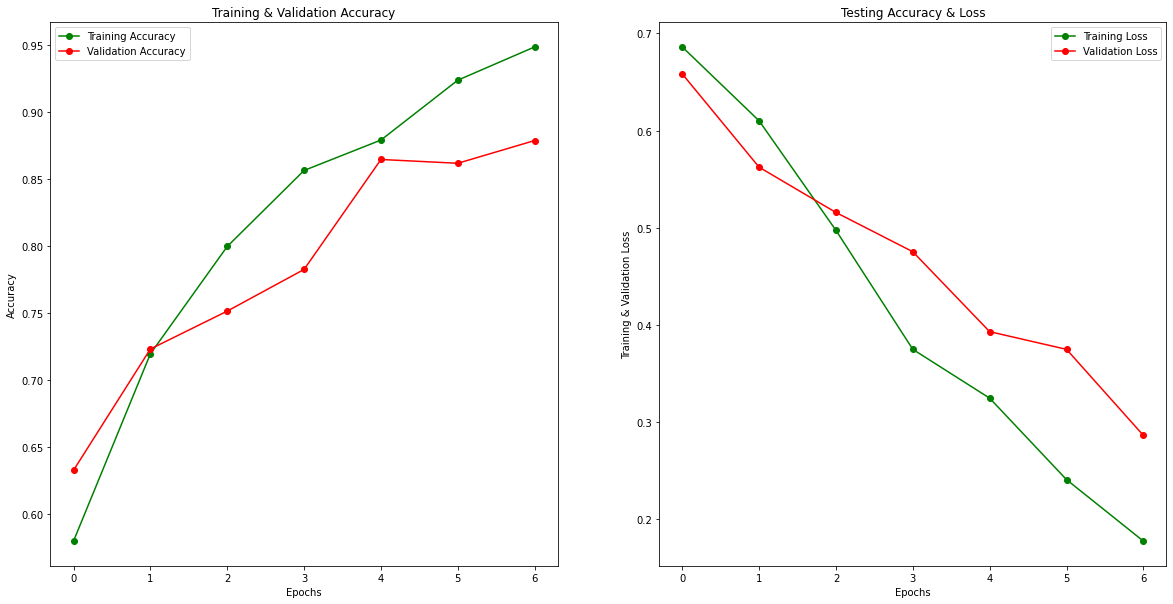

In [69]:
plot_accuracy(histories[categories[0]])

# as we see that method doing well in reports analysis